# Week 2

In [1]:
# =============================
# Standard Libraries
# =============================
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations
from joblib import parallel_backend
from tqdm.auto import tqdm
import kagglehub
from IPython.display import display


# =============================
# Data Science Libraries
# =============================
import numpy as np
import pandas as pd
import optuna

# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns

# =============================
# Scikit-learn
# =============================
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold,
    ParameterGrid,
)
import sklearn.model_selection._search as sk_search
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeClassifier, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import sklearn.model_selection._validation as sk_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# =============================
# Global
# =============================
random_state = 42
N_ROWS = 5_000_000  # sample size for all datasets
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

# =============================
# Utils
# =============================
def dollar_format(x, pos=None):
    return f"${x:,.0f}"

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

def try_read_csv(folder, fname, **kwargs):
    fp = os.path.join(folder, fname)
    return pd.read_csv(fp, **kwargs) if os.path.exists(fp) else None

def list_csvs(folder):
    return [f for f in os.listdir(folder) if f.lower().endswith(".csv")]

def simple_random_sample(steam, n_rows=None, frac=None, random_state=42):
    if steam is None:
        raise ValueError("steam is None")
    n = len(steam)
    if (n_rows is None) == (frac is None):
        raise ValueError("pass exactly one of n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        k = int(np.floor(frac * n))
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        k = min(int(n_rows), n)
    if k >= n:
        return steam.copy()
    t0 = time.perf_counter()
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n, size=k, replace=False)
    out = steam.iloc[idx].copy()
    t1 = time.perf_counter()
    print({"rows": n, "picked": int(len(out)), "frac": float(len(out) / n), "elapsed_sec": round(t1 - t0, 3)})
    return out

def stratified_sample(steam, y, n_rows=None, frac=None, random_state=42):
    if steam is None:
        raise ValueError("steam is None")
    y_arr = steam[y].to_numpy() if isinstance(y, str) else np.asarray(y)
    n = len(steam)
    if len(y_arr) != n:
        raise ValueError("X and y length mismatch")
    if n_rows is not None and frac is not None:
        frac = None
    if n_rows is None and frac is None:
        raise ValueError("provide n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        test_size = float(frac)
        use_frac, use_n = frac, None
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        test_size = min(float(n_rows) / n, 1.0)
        use_frac, use_n = None, int(n_rows)
    if test_size >= 1.0:
        return steam.copy()
    _, counts = np.unique(y_arr, return_counts=True)
    if np.any(counts < 2):
        print("Warning: some classes <2 samples; using simple sampling.")
        return simple_random_sample(steam, n_rows=use_n, frac=use_frac, random_state=random_state)
    t0 = time.perf_counter()
    idx = np.arange(n)
    _, test_idx, _, _ = train_test_split(
        idx, y_arr, test_size=test_size, stratify=y_arr, random_state=random_state
    )
    out = steam.iloc[test_idx].copy()
    t1 = time.perf_counter()
    print(
        {
            "rows": n,
            "picked": int(len(out)),
            "frac": float(len(out) / n),
            "elapsed_sec": round(t1 - t0, 3),
            "mode": "stratified",
        }
    )
    return out

# =============================
# Load Steam (sample first)
# =============================
steam_path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")
print("Steam path:", steam_path, "\n", os.listdir(steam_path))

games = try_read_csv(steam_path, "games.csv", low_memory=False)
users = try_read_csv(steam_path, "users.csv", low_memory=False)
recommendations = try_read_csv(steam_path, "recommendations.csv", low_memory=False)

metadata = None
meta_fp = os.path.join(steam_path, "games_metadata.json")
if os.path.exists(meta_fp):
    metadata = pd.read_json(meta_fp, lines=True)

print(
    "Steam shapes:",
    {
        "games": None if games is None else games.shape,
        "users": None if users is None else users.shape,
        "recommendations": None if recommendations is None else recommendations.shape,
        "metadata": None if metadata is None else metadata.shape,
    },
)

steam = None
if recommendations is not None:
    # sample recommendations
    if "is_recommended" in recommendations.columns:
        recs_sample = stratified_sample(recommendations, y="is_recommended", n_rows=N_ROWS, random_state=random_state)
    else:
        recs_sample = simple_random_sample(recommendations, n_rows=N_ROWS, random_state=random_state)

    gm = games
    if metadata is not None and "app_id" in metadata.columns and games is not None and "app_id" in games.columns:
        gm = games.merge(metadata, on="app_id", how="left")

    steam = recs_sample
    if gm is not None and "app_id" in recs_sample.columns and "app_id" in gm.columns:
        steam = steam.merge(gm, on="app_id", how="left")
    if users is not None and "user_id" in steam.columns and "user_id" in users.columns:
        steam = steam.merge(users, on="user_id", how="left")

    print("steam:", steam.shape)

# =============================
# Load Olist
# =============================
olist_path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("\nOlist path:", olist_path, "\n", os.listdir(olist_path))

olist_customers = try_read_csv(olist_path, "olist_customers_dataset.csv")
olist_geolocation = try_read_csv(olist_path, "olist_geolocation_dataset.csv")
olist_items = try_read_csv(olist_path, "olist_order_items_dataset.csv")
olist_payments = try_read_csv(olist_path, "olist_order_payments_dataset.csv")
olist_reviews = try_read_csv(olist_path, "olist_order_reviews_dataset.csv")
olist_orders = try_read_csv(olist_path, "olist_orders_dataset.csv")
olist_products = try_read_csv(olist_path, "olist_products_dataset.csv")
olist_sellers = try_read_csv(olist_path, "olist_sellers_dataset.csv")
olist_cat_trans = try_read_csv(olist_path, "product_category_name_translation.csv")

print(
    "Olist shapes:",
    {
        "customers": None if olist_customers is None else olist_customers.shape,
        "geolocation": None if olist_geolocation is None else olist_geolocation.shape,
        "items": None if olist_items is None else olist_items.shape,
        "payments": None if olist_payments is None else olist_payments.shape,
        "reviews": None if olist_reviews is None else olist_reviews.shape,
        "orders": None if olist_orders is None else olist_orders.shape,
        "products": None if olist_products is None else olist_products.shape,
        "sellers": None if olist_sellers is None else olist_sellers.shape,
        "category_translation": None if olist_cat_trans is None else olist_cat_trans.shape,
    },
)

olist = None
if all(x is not None for x in [olist_orders, olist_customers, olist_items, olist_products, olist_sellers]):
    # translated category names
    if olist_cat_trans is not None and "product_category_name" in olist_products.columns:
        products_en = olist_products.merge(olist_cat_trans, on="product_category_name", how="left")
    else:
        products_en = olist_products

    # enrich items with product and seller info
    items_ext = (
        olist_items.merge(products_en, on="product_id", how="left")
        .merge(olist_sellers, on="seller_id", how="left", suffixes=("", "_seller"))
    )

    # average lat,lng per ZIP prefix
    if olist_geolocation is not None:
        geo_zip = (
            olist_geolocation.groupby("geolocation_zip_code_prefix", as_index=False).agg(
                geolocation_lat=("geolocation_lat", "mean"),
                geolocation_lng=("geolocation_lng", "mean"),
                geo_points=("geolocation_city", "count"),
            )
        )
        customers_geo = (
            olist_customers.merge(
                geo_zip,
                left_on="customer_zip_code_prefix",
                right_on="geolocation_zip_code_prefix",
                how="left",
            )
            .drop(columns=["geolocation_zip_code_prefix"])
        )
    else:
        customers_geo = olist_customers

    payments_agg = (
        olist_payments.groupby("order_id", as_index=False).agg(
            payment_value_total=("payment_value", "sum"),
            payment_installments_max=("payment_installments", "max"),
            payment_count=("payment_type", "count"),
        )
        if olist_payments is not None
        else None
    )

    reviews_agg = (
        olist_reviews.groupby("order_id", as_index=False).agg(
            review_score_mean=("review_score", "mean"),
            review_count=("review_id", "count"),
        )
        if olist_reviews is not None
        else None
    )

    olist = (
        olist_orders.merge(customers_geo, on="customer_id", how="left")
        .merge(items_ext, on="order_id", how="left")
    )
    if payments_agg is not None:
        olist = olist.merge(payments_agg, on="order_id", how="left")
    if reviews_agg is not None:
        olist = olist.merge(reviews_agg, on="order_id", how="left")

    print("olist:", olist.shape)

    # sample Olist
    olist = simple_random_sample(olist, n_rows=N_ROWS, random_state=random_state)
    print("olist sample:", olist.shape)

# Run immediately after loading/creating `olist`
base_cols = [
    "order_id","customer_id","order_status","order_purchase_timestamp",
    "order_approved_at","order_delivered_carrier_date",
    "order_delivered_customer_date","order_estimated_delivery_date",
    "customer_unique_id","customer_zip_code_prefix","customer_city",
    "customer_state","geolocation_lat","geolocation_lng","geo_points",
    "order_item_id","product_id","seller_id","shipping_limit_date","price",
    "freight_value","product_category_name","product_name_lenght",
    "product_description_lenght","product_photos_qty","product_weight_g",
    "product_length_cm","product_height_cm","product_width_cm",
    "product_category_name_english","seller_zip_code_prefix","seller_city",
    "seller_state","payment_value_total","payment_installments_max",
    "payment_count","review_score_mean","review_count"
]

idx_map = {}
cols_set = set(olist.columns)
for i, name in enumerate(base_cols):
    if i in cols_set:
        idx_map[i] = name
    if str(i) in cols_set:
        idx_map[str(i)] = name

olist = olist.rename(columns=idx_map)


# =============================
# Load Video Games Sales 2019
# =============================
vg2019_path = kagglehub.dataset_download("ashaheedq/video-games-sales-2019")
print("\nVG2019 path:", vg2019_path, "\n", os.listdir(vg2019_path))

sales = None
csvs = list_csvs(vg2019_path)
target_csv = "vgsales-12-4-2019.csv" if "vgsales-12-4-2019.csv" in csvs else (csvs[0] if csvs else None)
if target_csv is not None:
    sales = pd.read_csv(os.path.join(vg2019_path, target_csv), low_memory=False)
    print("sales:", sales.shape, "| file:", target_csv)

    # sample VG2019
    if "Genre" in sales.columns:
        sales = stratified_sample(sales, y="Genre", n_rows=N_ROWS, random_state=random_state)
    else:
        sales = simple_random_sample(sales, n_rows=N_ROWS, random_state=random_state)
    print("sales sample:", sales.shape)
else:
    print("No CSV found in the video-games-sales-2019 dataset.")


# =============================
# Final summaries
# =============================
print("\nsteam sample:", None if steam is None else steam.shape)
print("olist sample:", None if olist is None else olist.shape)
print("sales sample:", None if sales is None else sales.shape)

Steam path: /Users/chandlercampbell/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28 
 ['recommendations.csv', 'users.csv', 'games.csv', 'games_metadata.json']
Steam shapes: {'games': (50872, 13), 'users': (14306064, 3), 'recommendations': (41154794, 8), 'metadata': (50872, 3)}
{'rows': 41154794, 'picked': 5000000, 'frac': 0.12149252891412844, 'elapsed_sec': 6.07, 'mode': 'stratified'}
steam: (5000000, 24)

Olist path: /Users/chandlercampbell/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2 
 ['olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']
Olist shapes: {'customers': (99441, 5), 'geolocation': (1000163, 5), 'items': (112650, 7), 'payments': (103886, 5), 'reviews': (99224, 7), 'orders': (99441,

# Steam Reviews

In [2]:
steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 24 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
 8   title           object 
 9   date_release    object 
 10  win             bool   
 11  mac             bool   
 12  linux           bool   
 13  rating          object 
 14  positive_ratio  int64  
 15  user_reviews    int64  
 16  price_final     float64
 17  price_original  float64
 18  discount        float64
 19  steam_deck      bool   
 20  description     object 
 21  tags            object 
 22  products        int64  
 23  reviews         int64  
dtypes: bool(5), float64(4), int64(9), object(6)
memory usage: 748.6+ MB


Target: positive_ratio
Number of features: 14
Features: ['helpful', 'funny', 'is_recommended', 'hours', 'win', 'mac', 'linux', 'user_reviews', 'price_final', 'price_original', 'discount', 'steam_deck', 'products', 'reviews']
Using all rows: 5000000

Train rows: 4000000  Test rows: 1000000

Finding good regularization values with 5-fold cross validation...
Best alpha for Ridge: 100.0
Best alpha for Lasso: 0.001
Best alpha for Elastic Net: 0.001
Best l1_ratio for Elastic Net: 0.5

Ridge results:
R^2: 0.1845
MAE: 7.345
RMSE: 10.1712
Alpha used: 100.0
Top 10 features by strength (abs coef):
is_recommended    3.438451
mac               1.731387
linux             1.386498
price_original   -1.131469
price_final       0.926345
hours            -0.501975
reviews          -0.334289
products         -0.293970
win              -0.251718
discount          0.164966



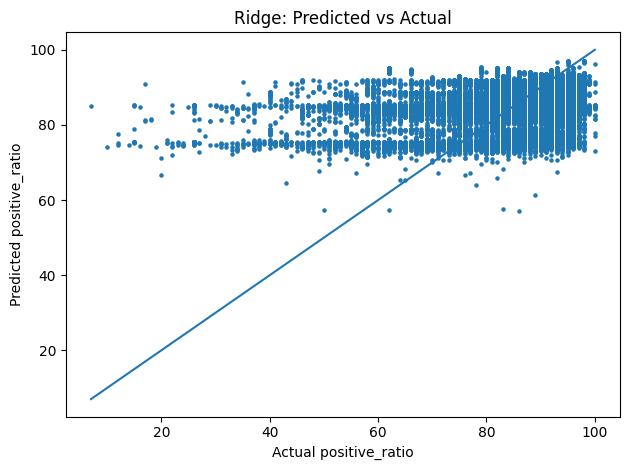

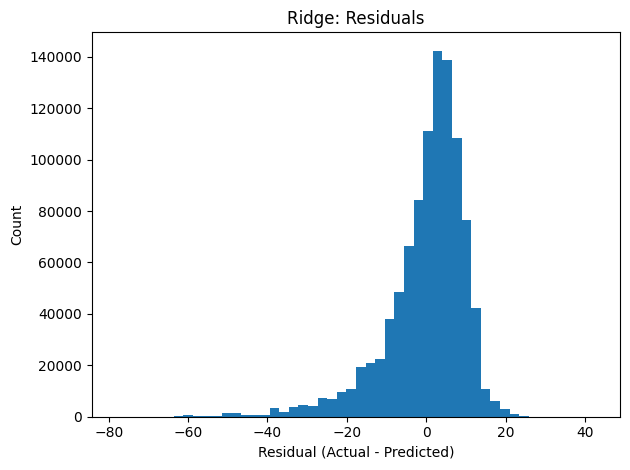

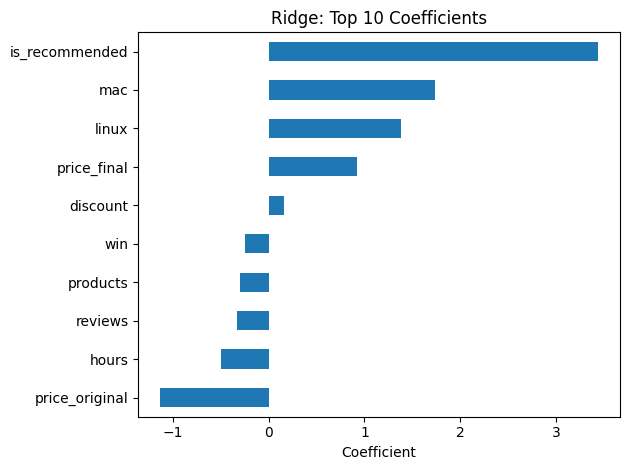

Lasso results:
R^2: 0.1845
MAE: 7.3452
RMSE: 10.1712
Alpha used: 0.001
Top 10 features by strength (abs coef):
is_recommended    3.437761
mac               1.731044
linux             1.385463
price_original   -1.129534
price_final       0.924533
hours            -0.500830
reviews          -0.333594
products         -0.293286
win              -0.250699
discount          0.163349



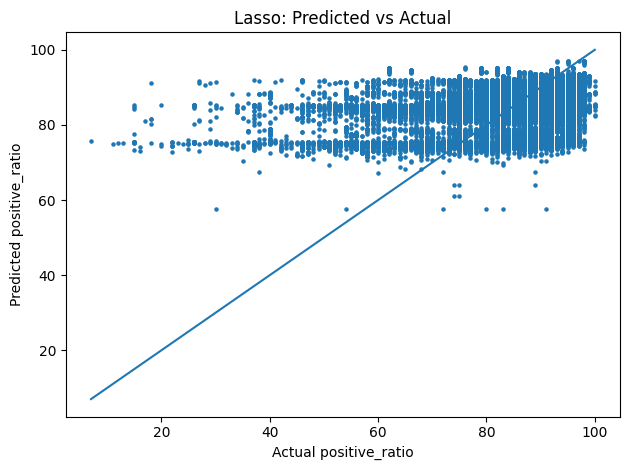

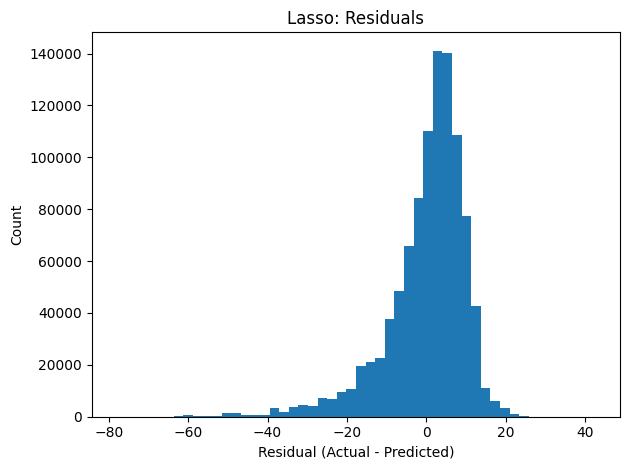

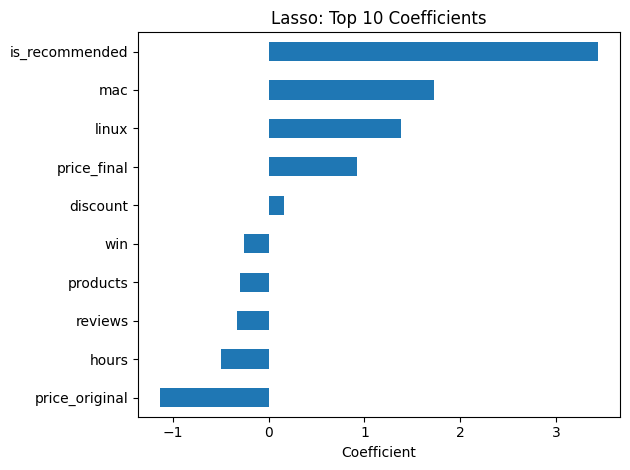

ElasticNet results:
R^2: 0.1845
MAE: 7.3451
RMSE: 10.1712
Alpha used: 0.001
l1_ratio used: 0.5
Top 10 features by strength (abs coef):
is_recommended    3.436496
mac               1.730690
linux             1.385667
price_original   -1.129709
price_final       0.924631
hours            -0.500920
reviews          -0.333887
products         -0.293601
win              -0.251080
discount          0.163822



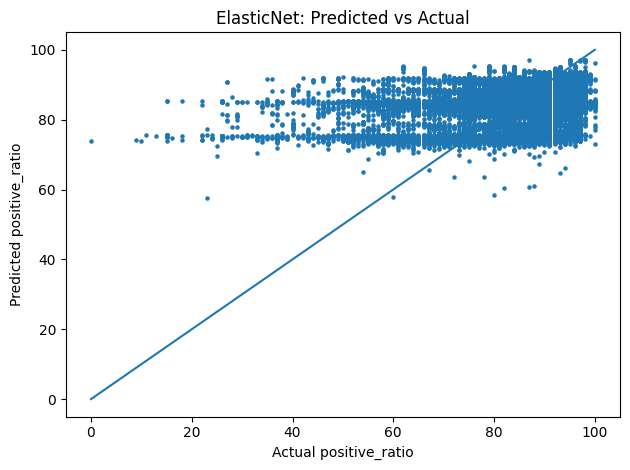

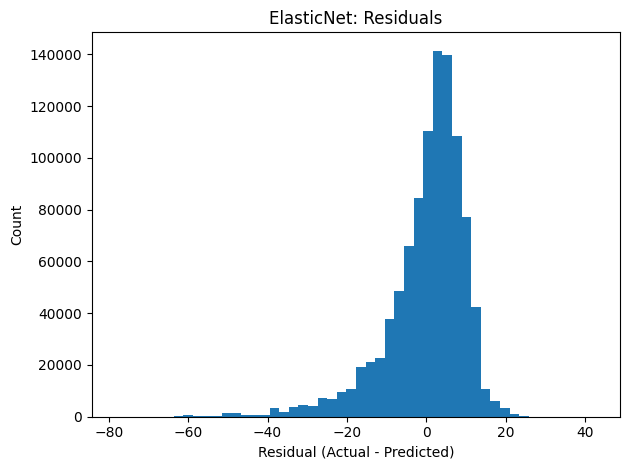

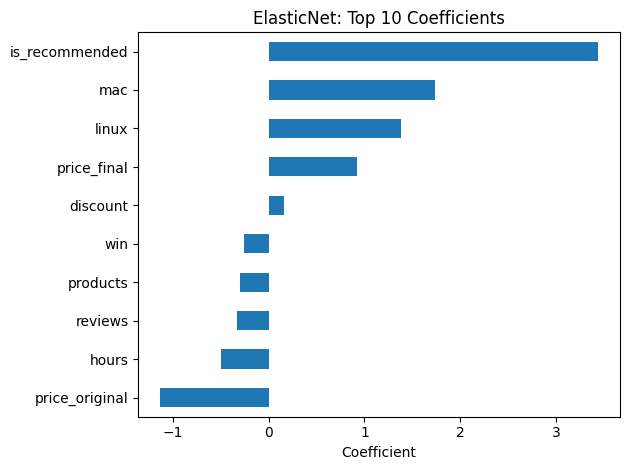

Model comparison. Higher R2 is better. Lower MAE and RMSE are better.


,Model,R2,MAE,RMSE
0,Ridge,0.184500,7.345000,10.171200
1,Lasso,0.184500,7.345200,10.171200
2,ElasticNet,0.184500,7.345100,10.171200


In [3]:
# ==========================================
# Ridge, Lasso, Elastic Net on steam df
# Target: positive_ratio
# ==========================================

# -----------------------------
# Target and features
# -----------------------------
TARGET = "positive_ratio"

# Use numeric and boolean columns as features
num_bool_cols = steam.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()

# Drop IDs that do not help prediction
drop_id_like = ["app_id", "user_id", "review_id"]

feature_cols = [c for c in num_bool_cols if c not in drop_id_like + [TARGET]]

X = steam[feature_cols].copy()
y = steam[TARGET].copy()

# Convert booleans to 0 or 1
for c in X.select_dtypes(include="bool").columns:
    X[c] = X[c].astype(int)

# Simple missing value handling
X = X.fillna(X.median(numeric_only=True))
y = y.fillna(y.median())

print("Target:", TARGET)
print("Number of features:", len(feature_cols))
print("Features:", feature_cols)
print("Using all rows:", len(X))
print()

# -----------------------------
# Train and test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train rows:", len(X_train), " Test rows:", len(X_test))
print()

# -----------------------------
# Scale features
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# Cross validation (cv=5)
# -----------------------------
alphas_ridge = np.logspace(-3, 3, 13)   # 0.001 to 1000
alphas_lasso = np.logspace(-3, 1, 9)    # 0.001 to 10
alphas_enet  = np.logspace(-3, 1, 9)    # 0.001 to 10
l1_ratios = [0.2, 0.5, 0.8]

print("Finding good regularization values with 5-fold cross validation...")
ridge_cv = RidgeCV(alphas=alphas_ridge, cv=5)
ridge_cv.fit(X_train_scaled, y_train)
best_alpha_ridge = float(ridge_cv.alpha_)
print("Best alpha for Ridge:", best_alpha_ridge)

lasso_cv = LassoCV(alphas=alphas_lasso, cv=5, max_iter=20000)
lasso_cv.fit(X_train_scaled, y_train)
best_alpha_lasso = float(lasso_cv.alpha_)
print("Best alpha for Lasso:", best_alpha_lasso)

enet_cv = ElasticNetCV(alphas=alphas_enet, l1_ratio=l1_ratios, cv=5, max_iter=20000)
enet_cv.fit(X_train_scaled, y_train)
best_alpha_enet = float(enet_cv.alpha_)
best_l1_ratio = float(enet_cv.l1_ratio_)
print("Best alpha for Elastic Net:", best_alpha_enet)
print("Best l1_ratio for Elastic Net:", best_l1_ratio)
print()

# -----------------------------
# Fit final models
# -----------------------------
ridge = Ridge(alpha=best_alpha_ridge)
lasso = Lasso(alpha=best_alpha_lasso, max_iter=20000)
enet = ElasticNet(alpha=best_alpha_enet, l1_ratio=best_l1_ratio, max_iter=20000)

models = {"Ridge": ridge, "Lasso": lasso, "ElasticNet": enet}
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))

    results[name] = {"model": model, "r2": r2, "mae": mae, "rmse": rmse}

    print(name, "results:")
    print("R^2:", round(r2, 4))
    print("MAE:", round(mae, 4))
    print("RMSE:", round(rmse, 4))

    if hasattr(model, "alpha"):
        print("Alpha used:", float(model.alpha))
    if name == "ElasticNet":
        print("l1_ratio used:", float(best_l1_ratio))

    # Top 10 features by absolute coefficient size
    coefs = pd.Series(model.coef_, index=feature_cols)
    top_coef = coefs.reindex(coefs.abs().sort_values(ascending=False).head(10).index)
    print("Top 10 features by strength (abs coef):")
    print(top_coef.to_string())
    print()

    # -----------------------------
    # Helpful graphs
    # -----------------------------

    # For scatter, use up to 50k points for clarity
    n_plot = min(50000, len(y_test))
    idx = np.random.choice(len(y_test), size=n_plot, replace=False)
    yt_plot = y_test.iloc[idx].to_numpy()
    yp_plot = y_pred[idx]

    # 1) Predicted vs Actual
    plt.figure()
    plt.scatter(yt_plot, yp_plot, s=5)
    plt.xlabel("Actual positive_ratio")
    plt.ylabel("Predicted positive_ratio")
    plt.title(f"{name}: Predicted vs Actual")
    min_val = float(min(yt_plot.min(), yp_plot.min()))
    max_val = float(max(yt_plot.max(), yp_plot.max()))
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.tight_layout()
    plt.show()

    # 2) Residuals histogram
    residuals = y_test.to_numpy() - y_pred
    plt.figure()
    plt.hist(residuals, bins=50)
    plt.xlabel("Residual (Actual - Predicted)")
    plt.ylabel("Count")
    plt.title(f"{name}: Residuals")
    plt.tight_layout()
    plt.show()

    # 3) Top coefficients bar chart
    plt.figure()
    top_coef.sort_values().plot(kind="barh")
    plt.xlabel("Coefficient")
    plt.title(f"{name}: Top 10 Coefficients")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Simple comparison table
# -----------------------------
summary = pd.DataFrame({
    "Model": list(results.keys()),
    "R2": [round(results[m]["r2"], 4) for m in results],
    "MAE": [round(results[m]["mae"], 4) for m in results],
    "RMSE": [round(results[m]["rmse"], 4) for m in results]
}).sort_values("R2", ascending=False)

print("Model comparison. Higher R2 is better. Lower MAE and RMSE are better.")
display(summary)


# Olist Transactions

In [4]:
olist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   customer_id                    113425 non-null  object 
 2   order_status                   113425 non-null  object 
 3   order_purchase_timestamp       113425 non-null  object 
 4   order_approved_at              113264 non-null  object 
 5   order_delivered_carrier_date   111457 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  113425 non-null  object 
 8   customer_unique_id             113425 non-null  object 
 9   customer_zip_code_prefix       113425 non-null  int64  
 10  customer_city                  113425 non-null  object 
 11  customer_state                 113425 non-null  object 
 12  geolocation_lat               

Target: price
Numeric features: 27
Categorical dummies: 127
Total features: 154
Using all rows: 113425

Train rows: 90740  Test rows: 22685

Finding good regularization values with 5-fold cross validation...
Best alpha for Ridge: 1000.0
Best alpha for Lasso: 0.03162277660168379
Best alpha for Elastic Net: 0.01
Best l1_ratio for Elastic Net: 0.2

Ridge results:
R^2: 0.7017
MAE: 45.5656
RMSE: 99.1309
Alpha used: 1000.0
Top 10 features by strength (abs coef):
order_item_id                                    -41.797987
product_category_name_english_office_furniture   -13.256674
product_category_name_english_fixed_telephony     -8.723124
product_weight_g                                   8.014207
product_description_lenght                        10.430176
product_category_name_english_watches_gifts       11.560132
product_category_name_english_computers           13.676039
payment_installments_max                          14.195959
freight_value                                     18.350576

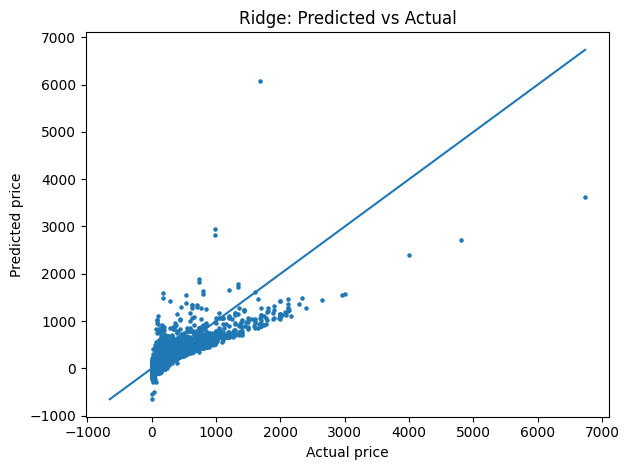

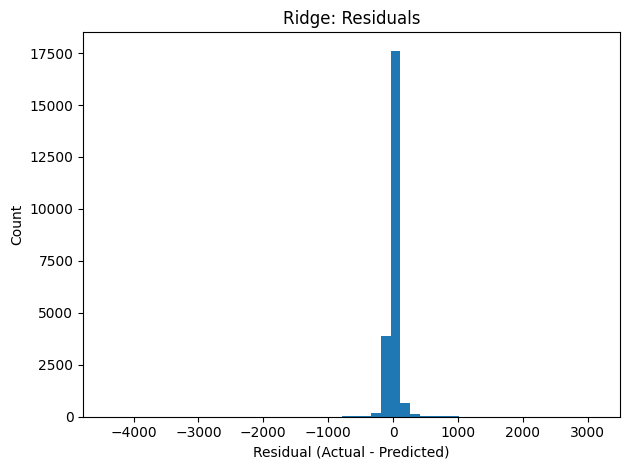

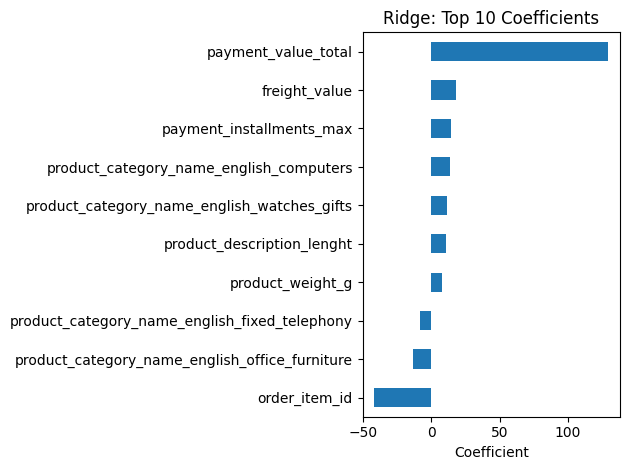

Lasso results:
R^2: 0.7024
MAE: 45.4022
RMSE: 99.0156
Alpha used: 0.03162277660168379
Top 10 features by strength (abs coef):
order_item_id                                    -42.793522
product_category_name_english_office_furniture   -13.177949
product_category_name_english_fixed_telephony     -8.990747
product_weight_g                                   7.788248
product_description_lenght                        10.287821
product_category_name_english_watches_gifts       11.696346
product_category_name_english_computers           13.590815
payment_installments_max                          14.019567
freight_value                                     18.012295
payment_value_total                              131.872550



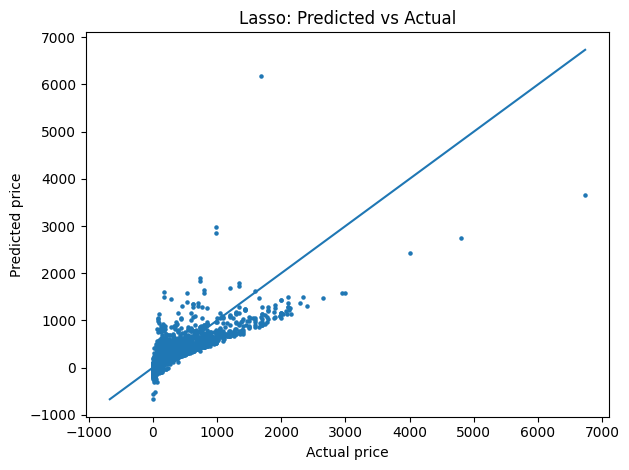

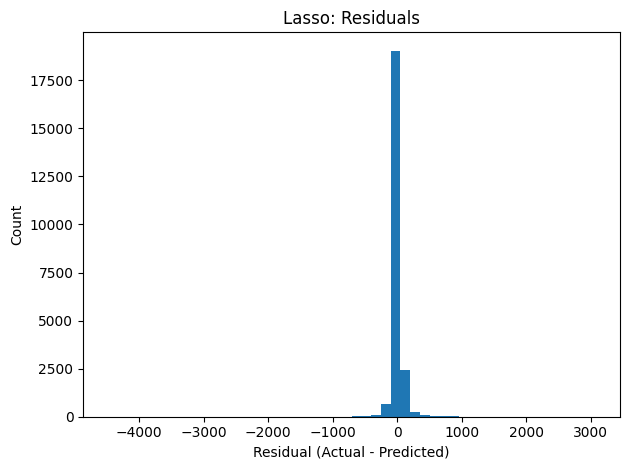

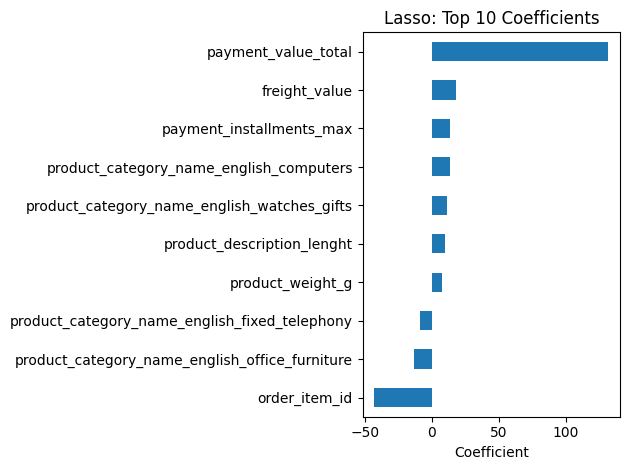

ElasticNet results:
R^2: 0.7019
MAE: 45.5309
RMSE: 99.0963
Alpha used: 0.01
l1_ratio used: 0.2
Top 10 features by strength (abs coef):
order_item_id                                    -42.065318
product_category_name_english_office_furniture   -13.365567
product_category_name_english_fixed_telephony     -8.845576
product_category_name_english_furniture_decor     -7.997952
product_description_lenght                        10.399897
product_category_name_english_watches_gifts       11.399066
product_category_name_english_computers           13.616447
payment_installments_max                          14.152172
freight_value                                     18.270731
payment_value_total                              130.318153



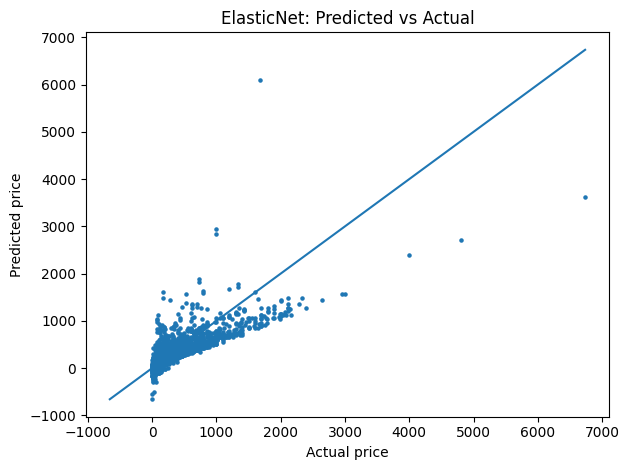

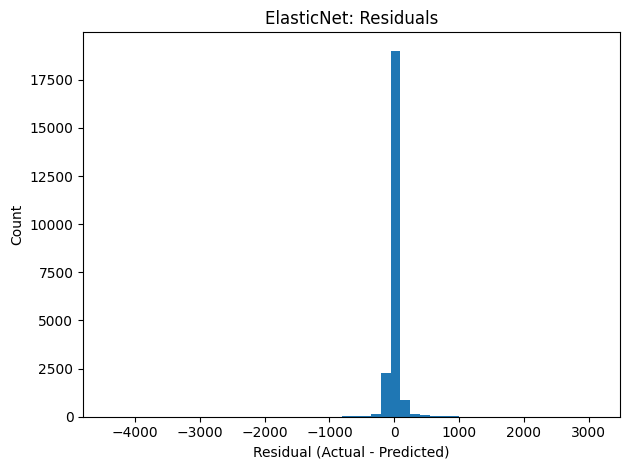

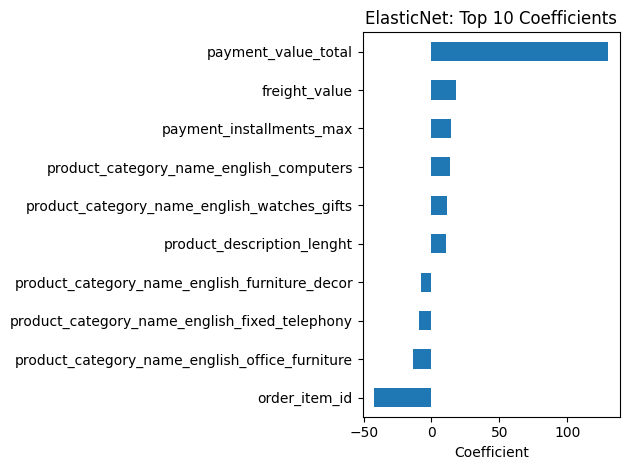

Model comparison. Higher R2 is better. Lower MAE and RMSE are better.


,Model,R2,MAE,RMSE
1,Lasso,0.702400,45.402200,99.015600
2,ElasticNet,0.701900,45.530900,99.096300
0,Ridge,0.701700,45.565600,99.130900


In [5]:
# ==========================================
# Ridge, Lasso, Elastic Net on olist df
# Target: price
# ==========================================

# -----------------------------
# Choose target
# -----------------------------
TARGET = "price"

# -----------------------------
# Copy and basic cleaning
# -----------------------------
df = olist.copy()

# Parse timestamps
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "shipping_limit_date",
]
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Simple date features
df["purchase_year"] = df["order_purchase_timestamp"].dt.year
df["purchase_month"] = df["order_purchase_timestamp"].dt.month
df["purchase_dow"] = df["order_purchase_timestamp"].dt.dayofweek
df["days_to_approve"] = (df["order_approved_at"] - df["order_purchase_timestamp"]).dt.total_seconds() / 86400.0
df["days_to_carrier"] = (df["order_delivered_carrier_date"] - df["order_purchase_timestamp"]).dt.total_seconds() / 86400.0
df["days_to_customer"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.total_seconds() / 86400.0
df["days_estimated"] = (df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]).dt.total_seconds() / 86400.0
df["delivery_delay_days"] = (df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]).dt.total_seconds() / 86400.0

# -----------------------------
# Feature selection
# -----------------------------
drop_id_like = [
    "order_id", "customer_id", "customer_unique_id",
    "product_id", "seller_id"
]

cat_cols = [
    "order_status",
    "customer_state",
    "seller_state",
    "product_category_name_english"
]

# Numeric candidates
num_feat_extra = [
    "purchase_year", "purchase_month", "purchase_dow",
    "days_to_approve", "days_to_carrier", "days_to_customer",
    "days_estimated", "delivery_delay_days"
]
num_candidates = set(df.select_dtypes(include=["int64", "float64"]).columns) | set(num_feat_extra)
num_features = [c for c in sorted(num_candidates) if c in df.columns and c not in drop_id_like + [TARGET]]

# One-hot encode selected categoricals
X_cat = pd.get_dummies(df[cat_cols].fillna("Unknown"), drop_first=True)

# Numeric matrix with simple median imputation
X_num = df[num_features].copy().fillna(df[num_features].median(numeric_only=True))

# Combine and ensure unique columns
X = pd.concat([X_num, X_cat], axis=1)
X = X.loc[:, ~X.columns.duplicated()].copy()
y = df[TARGET].fillna(df[TARGET].median())

feature_names = X.columns.tolist()

print("Target:", TARGET)
print("Numeric features:", len(X_num.columns))
print("Categorical dummies:", len(X_cat.columns))
print("Total features:", X.shape[1])
print("Using all rows:", len(X))
print()

# -----------------------------
# Train and test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train rows:", len(X_train), " Test rows:", len(X_test))
print()

# -----------------------------
# Scale features
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# Cross validation (cv=5)
# -----------------------------
alphas_ridge = np.logspace(-3, 3, 13)
alphas_lasso = np.logspace(-3, 1, 9)
alphas_enet  = np.logspace(-3, 1, 9)
l1_ratios = [0.2, 0.5, 0.8]

print("Finding good regularization values with 5-fold cross validation...")
ridge_cv = RidgeCV(alphas=alphas_ridge, cv=5)
ridge_cv.fit(X_train_scaled, y_train)
best_alpha_ridge = float(ridge_cv.alpha_)
print("Best alpha for Ridge:", best_alpha_ridge)

lasso_cv = LassoCV(alphas=alphas_lasso, cv=5, max_iter=40000, n_jobs=-1, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)
best_alpha_lasso = float(lasso_cv.alpha_)
print("Best alpha for Lasso:", best_alpha_lasso)

enet_cv = ElasticNetCV(alphas=alphas_enet, l1_ratio=l1_ratios, cv=5, max_iter=40000, n_jobs=-1, random_state=42)
enet_cv.fit(X_train_scaled, y_train)
best_alpha_enet = float(enet_cv.alpha_)
best_l1_ratio = float(enet_cv.l1_ratio_)
print("Best alpha for Elastic Net:", best_alpha_enet)
print("Best l1_ratio for Elastic Net:", best_l1_ratio)
print()

# -----------------------------
# Fit final models
# -----------------------------
ridge = Ridge(alpha=best_alpha_ridge, random_state=42)
lasso = Lasso(alpha=best_alpha_lasso, max_iter=40000, random_state=42)
enet = ElasticNet(alpha=best_alpha_enet, l1_ratio=best_l1_ratio, max_iter=40000, random_state=42)

models = {"Ridge": ridge, "Lasso": lasso, "ElasticNet": enet}
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))

    results[name] = {"model": model, "r2": r2, "mae": mae, "rmse": rmse}

    print(name, "results:")
    print("R^2:", round(r2, 4))
    print("MAE:", round(mae, 4))
    print("RMSE:", round(rmse, 4))

    if hasattr(model, "alpha"):
        print("Alpha used:", float(model.alpha))
    if name == "ElasticNet":
        print("l1_ratio used:", float(best_l1_ratio))

    # Top 10 features by absolute coefficient size
    coefs = pd.Series(model.coef_, index=feature_names)
    abs_coefs = coefs.abs()
    top_names = abs_coefs.nlargest(10).index
    top_coef = coefs.loc[top_names].sort_values()
    print("Top 10 features by strength (abs coef):")
    print(top_coef.to_string())
    print()

    # -----------------------------
    # Helpful graphs
    # -----------------------------
    n_plot = min(50000, len(y_test))
    idx = np.random.choice(len(y_test), size=n_plot, replace=False)
    yt_plot = y_test.iloc[idx].to_numpy()
    yp_plot = y_pred[idx]

    # 1) Predicted vs Actual
    plt.figure()
    plt.scatter(yt_plot, yp_plot, s=5)
    plt.xlabel("Actual price")
    plt.ylabel("Predicted price")
    plt.title(f"{name}: Predicted vs Actual")
    min_val = float(min(yt_plot.min(), yp_plot.min()))
    max_val = float(max(yt_plot.max(), yp_plot.max()))
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.tight_layout()
    plt.show()

    # 2) Residuals histogram
    residuals = y_test.to_numpy() - y_pred
    plt.figure()
    plt.hist(residuals, bins=50)
    plt.xlabel("Residual (Actual - Predicted)")
    plt.ylabel("Count")
    plt.title(f"{name}: Residuals")
    plt.tight_layout()
    plt.show()

    # 3) Top coefficients bar chart
    plt.figure()
    top_coef.sort_values().plot(kind="barh")
    plt.xlabel("Coefficient")
    plt.title(f"{name}: Top 10 Coefficients")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Simple comparison table
# -----------------------------
summary = pd.DataFrame({
    "Model": list(results.keys()),
    "R2": [round(results[m]["r2"], 4) for m in results],
    "MAE": [round(results[m]["mae"], 4) for m in results],
    "RMSE": [round(results[m]["rmse"], 4) for m in results]
}).sort_values("R2", ascending=False)

print("Model comparison. Higher R2 is better. Lower MAE and RMSE are better.")
display(summary)


# Video Game Sales

In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55792 entries, 0 to 55791
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rank            55792 non-null  int64  
 1   Name            55792 non-null  object 
 2   basename        55792 non-null  object 
 3   Genre           55792 non-null  object 
 4   ESRB_Rating     23623 non-null  object 
 5   Platform        55792 non-null  object 
 6   Publisher       55792 non-null  object 
 7   Developer       55775 non-null  object 
 8   VGChartz_Score  0 non-null      float64
 9   Critic_Score    6536 non-null   float64
 10  User_Score      335 non-null    float64
 11  Total_Shipped   1827 non-null   float64
 12  Global_Sales    19415 non-null  float64
 13  NA_Sales        12964 non-null  float64
 14  PAL_Sales       13189 non-null  float64
 15  JP_Sales        7043 non-null   float64
 16  Other_Sales     15522 non-null  float64
 17  Year            54813 non-null 

Target: Global_Sales
Using all rows: 55792

Train rows: 44633  Test rows: 11159

Finding good regularization values with 5-fold cross validation...


/var/folders/rv/ykggspv13l50b7nthk6kwm6r0000gn/T/ipykernel_2204/3059233941.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Last_Update"] = pd.to_datetime(df["Last_Update"], errors="coerce")


Best alpha for Ridge: 316.22776601683796
Best alpha for Lasso: 0.001
Best alpha for Elastic Net: 0.001
Best l1_ratio for Elastic Net: 0.2

Ridge results:
R^2: 0.1198
MAE: 0.179
RMSE: 0.4843
Alpha used: 316.22776601683796
Top 10 features by strength (abs coef):
ESRB_Rating_Unknown   -0.048844
Platform_PC           -0.045698
Platform_PSN          -0.031747
Platform_XBL          -0.025667
Year                  -0.024078
Platform_PS4           0.026223
Platform_X360          0.038778
Platform_PS3           0.040397
ESRB_Rating_M          0.055716
Critic_Score           0.064571



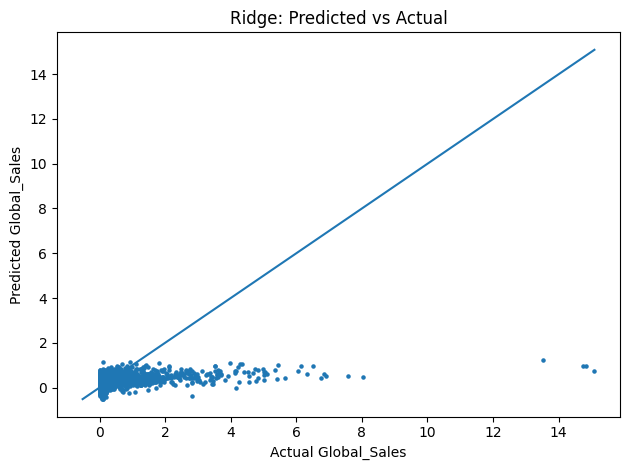

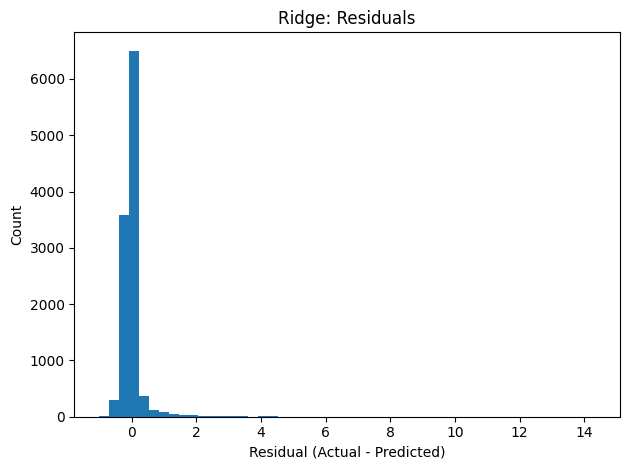

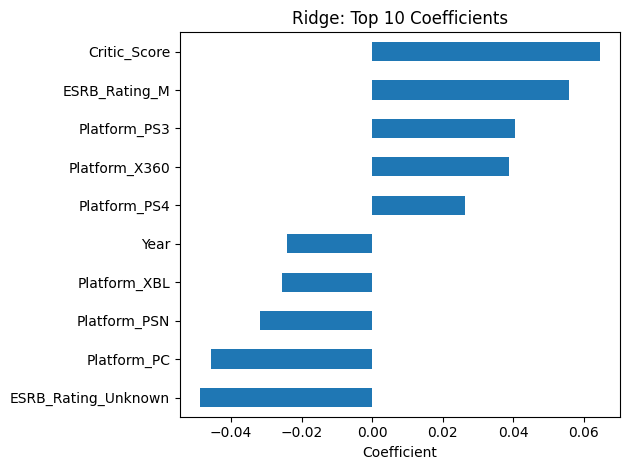

Lasso results:
R^2: 0.1192
MAE: 0.177
RMSE: 0.4845
Alpha used: 0.001
Top 10 features by strength (abs coef):
ESRB_Rating_Unknown   -0.067694
Platform_PC           -0.020107
last_update_month     -0.019793
Vgchartzscore          0.019172
Platform_PS2           0.034676
Platform_PS4           0.035206
ESRB_Rating_M          0.046209
Platform_X360          0.049037
Platform_PS3           0.051020
Critic_Score           0.063909



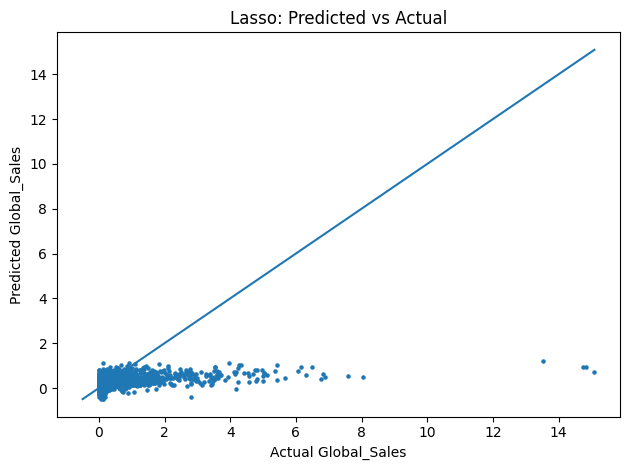

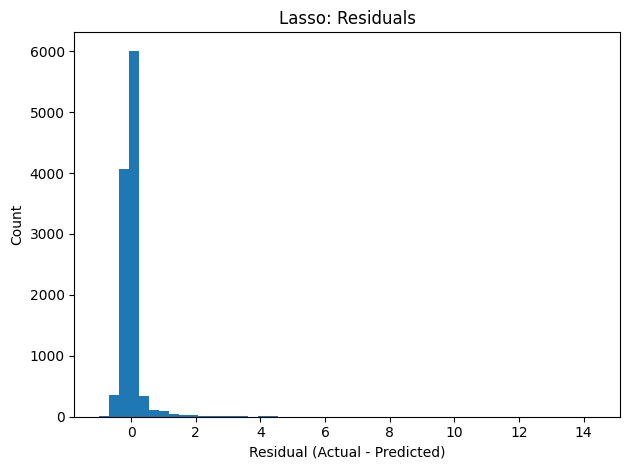

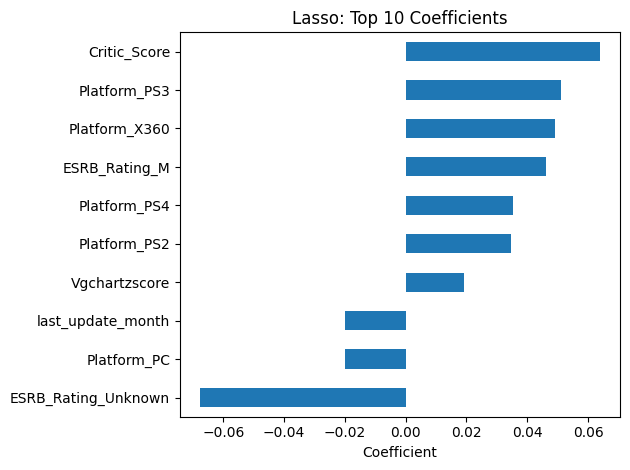

ElasticNet results:
R^2: 0.1199
MAE: 0.1787
RMSE: 0.4843
Alpha used: 0.001
l1_ratio used: 0.2
Top 10 features by strength (abs coef):
ESRB_Rating_Unknown   -0.067542
Platform_PC           -0.032146
Platform_PSN          -0.025167
Year                  -0.023981
Platform_PS2           0.027881
Platform_PS4           0.032405
Platform_X360          0.044872
Platform_PS3           0.046808
ESRB_Rating_M          0.046926
Critic_Score           0.064793



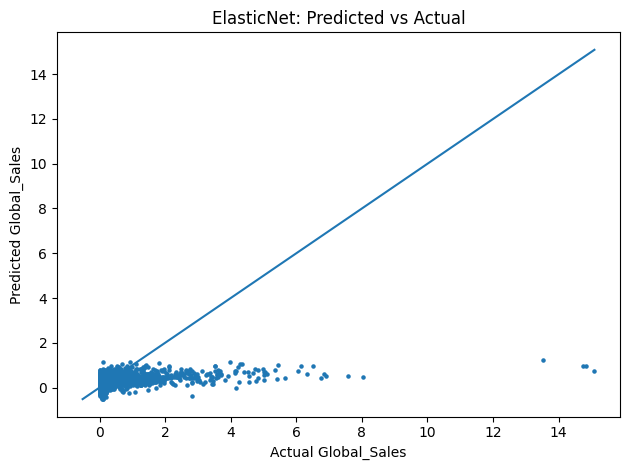

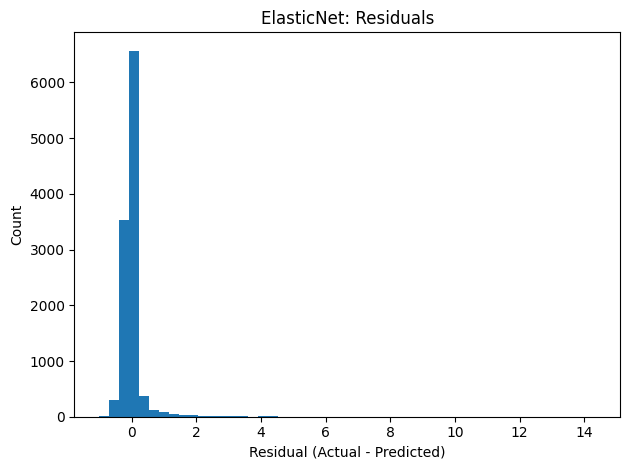

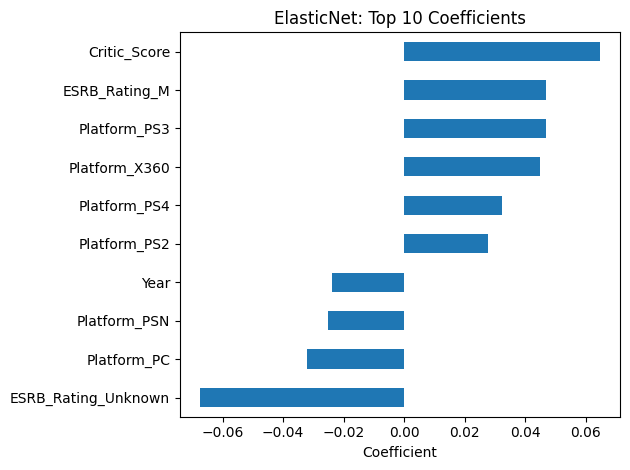

Model comparison. Higher R2 is better. Lower MAE and RMSE are better.


,Model,R2,MAE,RMSE
2,ElasticNet,0.119900,0.178700,0.484300
0,Ridge,0.119800,0.179000,0.484300
1,Lasso,0.119200,0.177000,0.484500


In [7]:
# ==========================================
# Ridge, Lasso, Elastic Net on sales df
# Target: Global_Sales
# ==========================================

# -----------------------------
# Choose target
# -----------------------------
TARGET = "Global_Sales"

# -----------------------------
# Copy and basic cleaning
# -----------------------------
df = sales.copy()

# Parse timestamp-like column
if "Last_Update" in df.columns:
    df["Last_Update"] = pd.to_datetime(df["Last_Update"], errors="coerce")

# Simple date features
df["last_update_year"] = df["Last_Update"].dt.year
df["last_update_month"] = df["Last_Update"].dt.month
df["decade"] = (df["Year"] // 10) * 10 if "Year" in df.columns else np.nan

# -----------------------------
# Feature selection
# -----------------------------
# Keep IDs out of features
drop_id_like = ["Rank"]

# Leakage columns (drop when predicting Global_Sales)
leakage_cols = ["NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"]

# Categorical columns to one-hot (kept small)
cat_cols = ["Genre", "ESRB_Rating", "Platform"]

# Numeric candidates
num_feat_extra = ["last_update_year", "last_update_month", "decade"]
num_candidates = set(df.select_dtypes(include=["int64", "float64"]).columns) | set(num_feat_extra)

# Build numeric features list (no ids, no target, no leakage)
num_features = [
    c for c in sorted(num_candidates)
    if c in df.columns and c not in drop_id_like + [TARGET] + leakage_cols
]

# One-hot encode selected categoricals
X_cat = pd.get_dummies(df[cat_cols].fillna("Unknown"), drop_first=True)

# Numeric matrix with simple median imputation
X_num = df[num_features].copy().fillna(df[num_features].median(numeric_only=True))
# Any column that was all-NaN becomes 0 now
X_num = X_num.fillna(0.0)

# Combine and ensure unique columns
X = pd.concat([X_num, X_cat], axis=1)
X = X.loc[:, ~X.columns.duplicated()].copy()
y = df[TARGET].fillna(df[TARGET].median())

# Drop constant columns to avoid scaler divide-by-zero
const_cols = X.columns[X.nunique(dropna=False) <= 1]
if len(const_cols) > 0:
    X = X.drop(columns=const_cols)

feature_names = X.columns.tolist()

print("Target:", TARGET)
print("Using all rows:", len(X))
print()

# -----------------------------
# Train and test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train rows:", len(X_train), " Test rows:", len(X_test))
print()

# -----------------------------
# Scale features
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# Cross validation (cv=5)
# -----------------------------
alphas_ridge = np.logspace(-3, 3, 13)
alphas_lasso = np.logspace(-3, 1, 9)
alphas_enet  = np.logspace(-3, 1, 9)
l1_ratios = [0.2, 0.5, 0.8]

print("Finding good regularization values with 5-fold cross validation...")
ridge_cv = RidgeCV(alphas=alphas_ridge, cv=5)
ridge_cv.fit(X_train_scaled, y_train)
best_alpha_ridge = float(ridge_cv.alpha_)
print("Best alpha for Ridge:", best_alpha_ridge)

lasso_cv = LassoCV(alphas=alphas_lasso, cv=5, max_iter=40000, n_jobs=-1, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)
best_alpha_lasso = float(lasso_cv.alpha_)
print("Best alpha for Lasso:", best_alpha_lasso)

enet_cv = ElasticNetCV(alphas=alphas_enet, l1_ratio=l1_ratios, cv=5, max_iter=40000, n_jobs=-1, random_state=42)
enet_cv.fit(X_train_scaled, y_train)
best_alpha_enet = float(enet_cv.alpha_)
best_l1_ratio = float(enet_cv.l1_ratio_)
print("Best alpha for Elastic Net:", best_alpha_enet)
print("Best l1_ratio for Elastic Net:", best_l1_ratio)
print()

# -----------------------------
# Fit final models
# -----------------------------
ridge = Ridge(alpha=best_alpha_ridge, random_state=42)
lasso = Lasso(alpha=best_alpha_lasso, max_iter=40000, random_state=42)
enet = ElasticNet(alpha=best_alpha_enet, l1_ratio=best_l1_ratio, max_iter=40000, random_state=42)

models = {"Ridge": ridge, "Lasso": lasso, "ElasticNet": enet}
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))

    results[name] = {"model": model, "r2": r2, "mae": mae, "rmse": rmse}

    print(name, "results:")
    print("R^2:", round(r2, 4))
    print("MAE:", round(mae, 4))
    print("RMSE:", round(rmse, 4))

    if hasattr(model, "alpha"):
        print("Alpha used:", float(model.alpha))
    if name == "ElasticNet":
        print("l1_ratio used:", float(best_l1_ratio))

    # Top 10 features by absolute coefficient size
    coefs = pd.Series(model.coef_, index=feature_names)
    abs_coefs = coefs.abs()
    top_names = abs_coefs.nlargest(10).index
    top_coef = coefs.loc[top_names].sort_values()
    print("Top 10 features by strength (abs coef):")
    print(top_coef.to_string())
    print()

    # -----------------------------
    # Helpful graphs
    # -----------------------------
    n_plot = min(30000, len(y_test))
    idx = np.random.choice(len(y_test), size=n_plot, replace=False)
    yt_plot = y_test.iloc[idx].to_numpy()
    yp_plot = y_pred[idx]

    # 1) Predicted vs Actual
    plt.figure()
    plt.scatter(yt_plot, yp_plot, s=5)
    plt.xlabel("Actual Global_Sales")
    plt.ylabel("Predicted Global_Sales")
    plt.title(f"{name}: Predicted vs Actual")
    min_val = float(min(yt_plot.min(), yp_plot.min()))
    max_val = float(max(yt_plot.max(), yp_plot.max()))
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.tight_layout()
    plt.show()

    # 2) Residuals histogram
    residuals = y_test.to_numpy() - y_pred
    plt.figure()
    plt.hist(residuals, bins=50)
    plt.xlabel("Residual (Actual - Predicted)")
    plt.ylabel("Count")
    plt.title(f"{name}: Residuals")
    plt.tight_layout()
    plt.show()

    # 3) Top coefficients bar chart
    plt.figure()
    top_coef.sort_values().plot(kind="barh")
    plt.xlabel("Coefficient")
    plt.title(f"{name}: Top 10 Coefficients")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Simple comparison table
# -----------------------------
summary = pd.DataFrame({
    "Model": list(results.keys()),
    "R2": [round(results[m]["r2"], 4) for m in results],
    "MAE": [round(results[m]["mae"], 4) for m in results],
    "RMSE": [round(results[m]["rmse"], 4) for m in results]
}).sort_values("R2", ascending=False)

print("Model comparison. Higher R2 is better. Lower MAE and RMSE are better.")
display(summary)
